# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

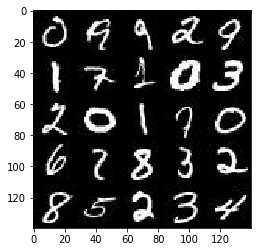

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

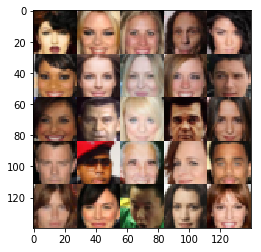

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return (inputs_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1) Adding hidden layers
        # 2) Applying Leaky ReLU
        # 3) Applying batch normalization
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        h1 = tf.maximum(alpha*h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha*h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha*h3, h3)

        h3 = tf.nn.dropout(h3, keep_prob=0.5)
        
        h3 = tf.reshape(h3, (-1, 4*4*256))
        
        # fully connected
        logits = tf.layers.dense(h3, 1)
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=(not is_train)):
       # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Label Smooth
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    # Create Model Inputs 
    _, img_width, img_height, img_channels = data_shape
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)    
    
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    steps = 0

    # sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    # to use at show generator output function
    n_images = 25 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5987... Generator Loss: 2.3508
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 4.8320
Epoch 1/2... Discriminator Loss: 1.0605... Generator Loss: 1.9785
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 1.4472
Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 1.4595
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 2.4056
Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 2.0264
Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 1.3389
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 1.0329


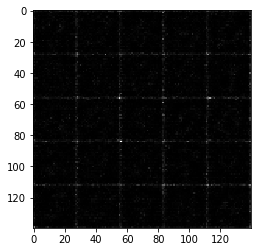

Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 1.1402
Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 2.8030
Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 1.8208
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 1.7047
Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 2.5612
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.0384
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 1.5991
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 2.0893
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 0.7619


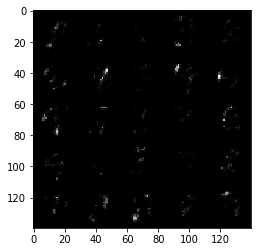

Epoch 1/2... Discriminator Loss: 0.8408... Generator Loss: 1.9516
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 1.2184
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 1.6072
Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 2.0628
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.8167
Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 1.8188
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.2563
Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 1.5288
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 1.6621


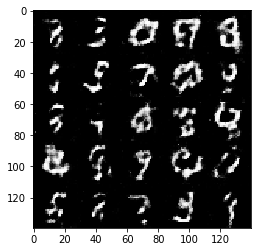

Epoch 1/2... Discriminator Loss: 0.9666... Generator Loss: 1.1976
Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 2.4800
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.4980
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 2.1971
Epoch 1/2... Discriminator Loss: 0.9742... Generator Loss: 0.9943
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 2.3892
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 2.6169
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 2.0678
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 1.1526


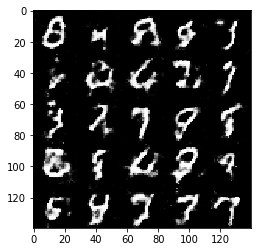

Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 1.2094
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 2.2335
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 1.7927
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 1.5320
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 1.6949
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 1.2729
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 1.7287
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.7893


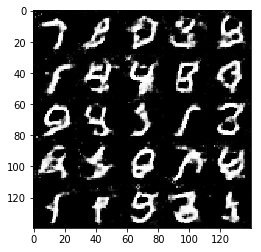

Epoch 1/2... Discriminator Loss: 0.9605... Generator Loss: 1.6764
Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 1.2477
Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 1.8496
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 1.0601... Generator Loss: 1.1310
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 2.2912
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 1.4845
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.9092


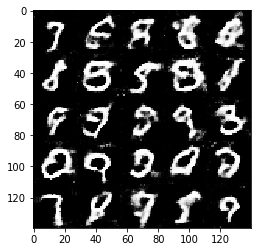

Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 1.3567
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.9952
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 1.3261
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.8541
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 1.1126
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 1.8412
Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 1.3807
Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 0.5018
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 1.5446
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 1.1847


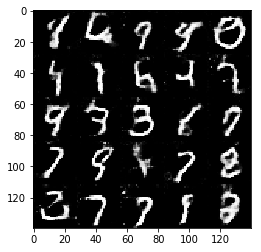

Epoch 1/2... Discriminator Loss: 1.0522... Generator Loss: 1.2290
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 1.9292
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 1.5996
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 1.5728
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 1.5268
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 1.5036
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 1.3549
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 2.0327


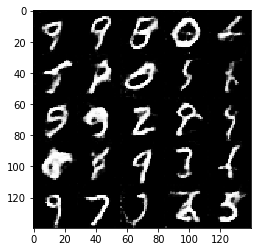

Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 1.5045
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.3587
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 1.5095
Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 1.7450
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 1.8168


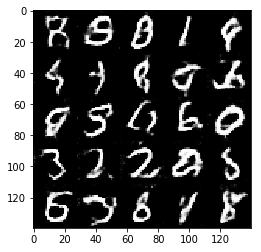

Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 1.4491
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.1844
Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 1.3588
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 2.0055
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 1.4053
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 0.9532... Generator Loss: 1.3688
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.9669
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 1.5359
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 1.1867


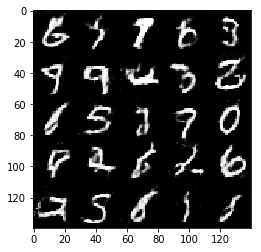

Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 0.8358
Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 1.4171
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 1.0599
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 1.3981
Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 1.4487
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.1402
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 1.0811
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.7618


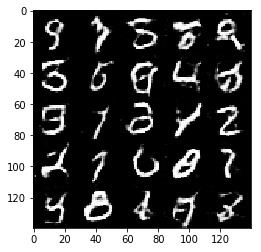

Epoch 2/2... Discriminator Loss: 1.0038... Generator Loss: 1.0777
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 1.7502
Epoch 2/2... Discriminator Loss: 1.0683... Generator Loss: 1.4012
Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 1.0609
Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 1.1349
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 1.7003
Epoch 2/2... Discriminator Loss: 1.1481... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 1.1515
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.8916


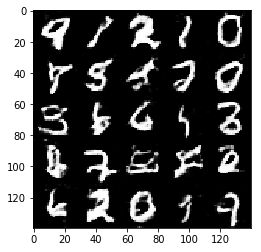

Epoch 2/2... Discriminator Loss: 1.1003... Generator Loss: 1.2833
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 1.1898
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 1.0280
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 1.3460
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 1.2199
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 1.7760
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 1.1705
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 1.2745


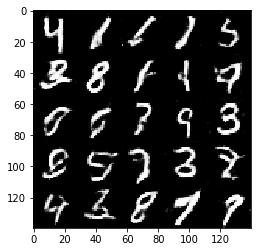

Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 2.0569
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 1.2734
Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 1.2909
Epoch 2/2... Discriminator Loss: 1.5000... Generator Loss: 0.5683
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 1.0583
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 1.2696
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 1.4176
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 1.4226
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 2.1550


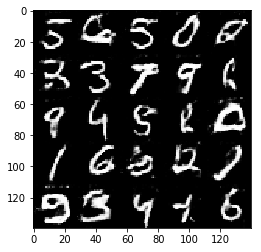

Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 1.4987
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 1.8542
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 1.2557
Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 1.0202
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 1.8786
Epoch 2/2... Discriminator Loss: 1.0180... Generator Loss: 1.1776
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 1.4353
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 2.5200
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 0.9621


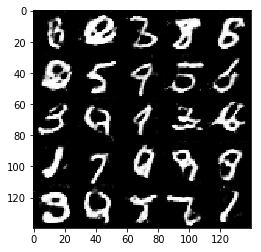

Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.9059
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 1.6920
Epoch 2/2... Discriminator Loss: 1.1221... Generator Loss: 1.0601
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.1009
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 1.9596
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 1.7327... Generator Loss: 2.5577
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 1.3702


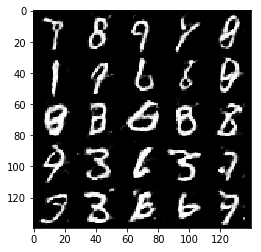

Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.6573
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.3158
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 1.4948
Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 1.6547
Epoch 2/2... Discriminator Loss: 1.0287... Generator Loss: 1.1075
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 1.5517
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 1.3956
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 1.4532
Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 1.5520


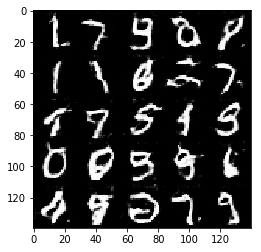

Epoch 2/2... Discriminator Loss: 0.9100... Generator Loss: 1.3768
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 1.1879
Epoch 2/2... Discriminator Loss: 1.1499... Generator Loss: 0.9674
Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 1.8649
Epoch 2/2... Discriminator Loss: 1.0369... Generator Loss: 2.2673
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 1.4853
Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 1.9012
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 1.9205
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 1.5209
Epoch 2/2... Discriminator Loss: 0.9333... Generator Loss: 1.5301


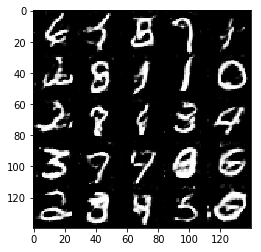

Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.1060
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 1.4463
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 1.1532
Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 0.9841
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 1.6534
Epoch 2/2... Discriminator Loss: 0.9035... Generator Loss: 1.5791


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 3.4919
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 4.1122
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 3.8790
Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 4.2116
Epoch 1/1... Discriminator Loss: 0.6153... Generator Loss: 3.5281
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 2.0674
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 3.4735
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 3.3748
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 3.5437
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 4.0742


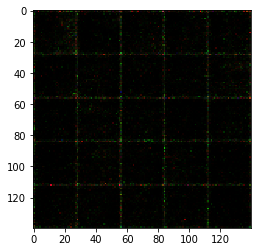

Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 4.0199
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 2.5443
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 3.8739
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 2.3957
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 2.4592
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 3.3768
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.7783
Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 3.6654
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.9910


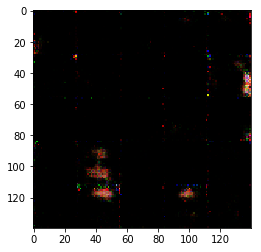

Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 4.2292
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 2.2293
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 2.2798
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.3464
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 2.3020
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 2.3445
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 3.0217
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 4.1533
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 4.3853


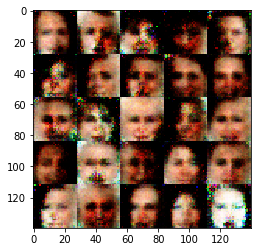

Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.8829
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 2.2224
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 3.1754
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 2.8065
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 4.4629
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 2.5181
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 3.4414
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 5.4365
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 2.4453


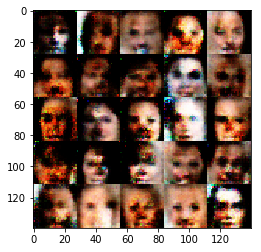

Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 2.5888
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 2.1402
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 2.4927
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 2.4088
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 2.0084
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 3.1296
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 3.4944
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.9667
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.5970
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 3.0225


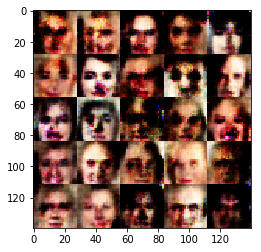

Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 2.0071
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 2.2781... Generator Loss: 3.9803
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.4489
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.0724
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 2.2460
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.0255


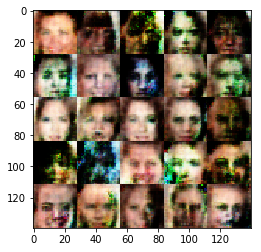

Epoch 1/1... Discriminator Loss: 1.8217... Generator Loss: 4.1936
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.8422
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 2.4586
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.7382
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.2920
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 1.9754
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.9448


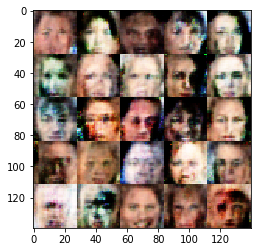

Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.4046
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 1.6384
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 2.1189
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.5127
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.2365


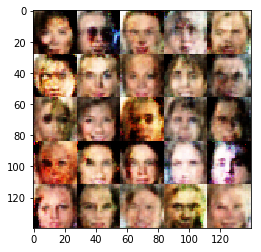

Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.6365
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.3568
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.3850
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.9201
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.1174


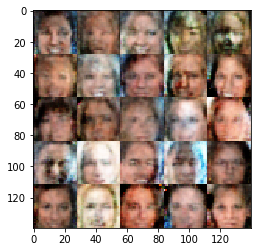

Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.1606
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.4086
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.7014


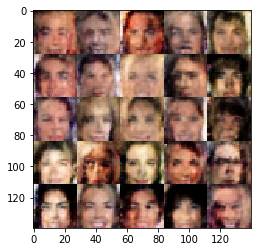

Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.5518
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 1.4481


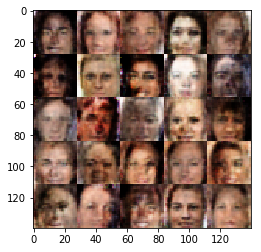

Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.9355


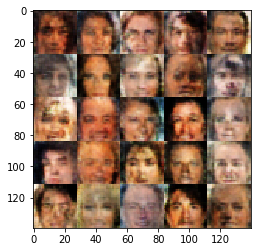

Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7792


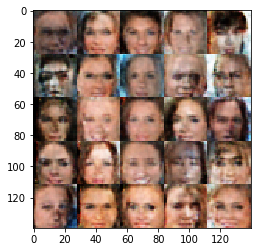

Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.2654


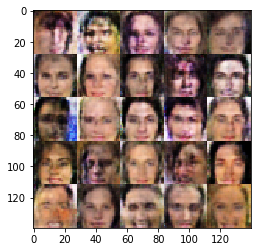

Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.8893


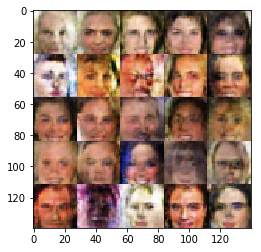

Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 1.0038


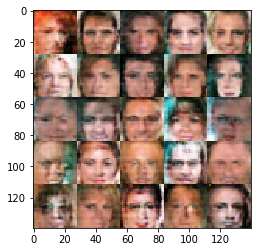

Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 1.0432


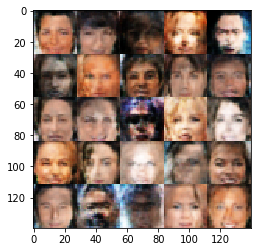

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.9281


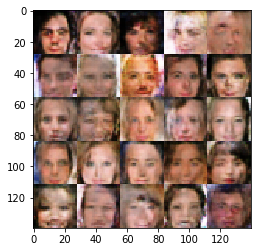

Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.3200


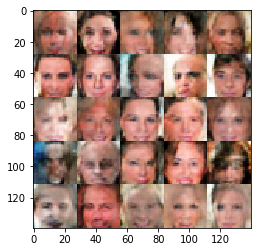

Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.9687


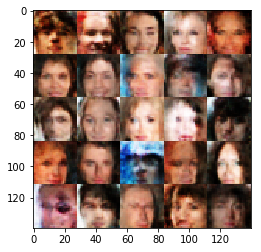

Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 1.2214
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 1.2009


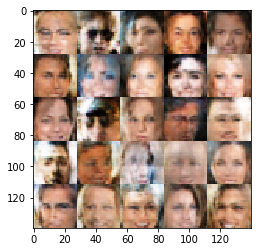

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.9922


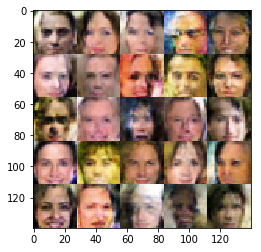

Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8999


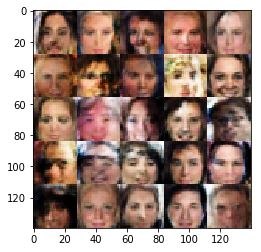

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7570


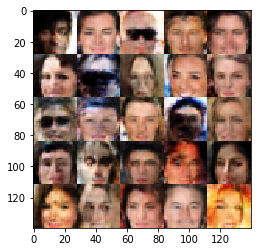

Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.0894


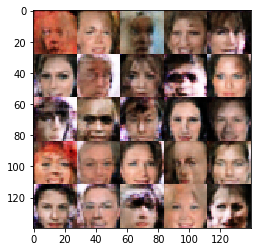

Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.1697
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.9710


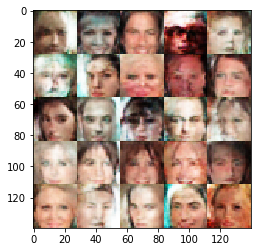

Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.9081


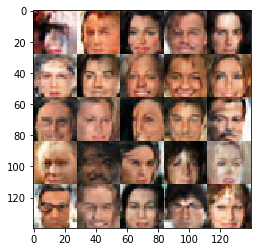

Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.9985


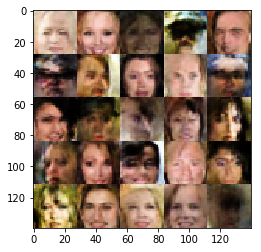

Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.8588


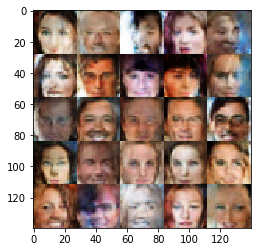

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.1805
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8622


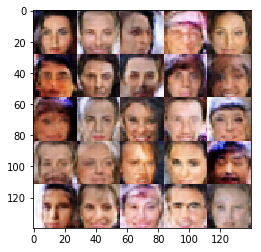

Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.9030


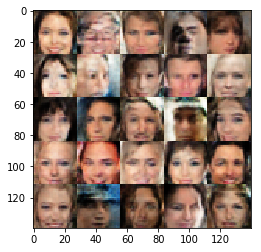

Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.1523


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.